# Workshop 6: Fitting

**Submit this notebook to bCourses to receive a grade for this Workshop.**

Please complete workshop activities in code cells in this iPython notebook. The activities titled **Practice** are purely for you to explore Python, and no particular output is expected. Some of them have some code written, and you should try to modify it in different ways to understand how it works. Although no particular output is expected at submission time, it is _highly_ recommended that you read and work through the practice activities before or alongside the exercises. However, the activities titled **Exercise** have specific tasks and specific outputs expected. Include comments in your code when necessary. Enter your name in the cell at the top of the notebook. 

**The workshop should be submitted on bCourses under the Assignments tab (both the .ipynb and .pdf files).**

## Fitting

The simplest technique for fitting is called least-squares fitting. Usually you use the least-squares fit if you have a set of data (pairs of data points $(x_i, y_i)$ ), and you want to describe it in terms of a model $y(x;\{a_j\})$, where parameters $\{a_j\}$ are unknown. The purpose of your fit is to determine the values of $\{a_j\} = \{a_0, a_1, ...\}$ and (hopefully) their uncertainties. An example of a model is:

$$y = a_0 + a_1 x$$

where the unknown parameters $a_j$ are $a_0$ and $a_1$.

There are two standard cases where least-squares method is applicable:
1. You know errors for each data point $\sigma_i$ and you know that those errors follow a Gaussian distribution. In this case, you minimize $\chi^2=\sum \left(\frac{y_i - y(x_i;\{a_j\})}{\sigma_i}\right)^2$ with respect to the parameters $\{a_j\}$. The value of the $\chi^2_{\min}$ can be interpreted as a goodness-of-fit. The parameters $\{a_j\}$ that minimize the $\chi^2$ have a probabilistic interpretation.
1. You know that the errors are Gaussian and are the same for each data point, but you do not know their magnitude. In this case, you would minimize the sum of squares: $\mathcal{S} = \sum \left(y_i - y(x_i;\{a_j\})\right)^2$. Then value of $\mathcal{S}$ can be used to *estimate* the errors $\sigma_i$ for each data point using the following formula: $\sigma_i = \sqrt{\mathcal{S}/(N_\mathrm{data}-N_\mathrm{parameters})}$
The errors on $\{a_j\}$ have a probabilistic definition, but you lose information about the goodness of fit.
1. If the errors are not known to be Gaussian, then the least square method is not useful to estimate uncertainties or the goodness of fit. It is also not guaranteed to be unbiased or most efficient (see the lecture for a discussion of these properties of estimators).

### Polynomial $\chi^2$ fit


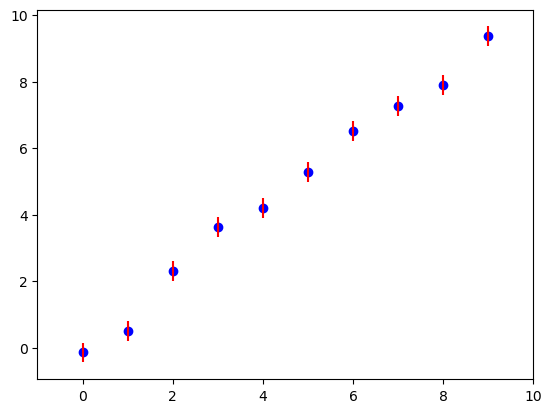

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as fitter
%matplotlib inline

# Generate artificial data = straight line with a=0 and b=1
# plus some noise.
a0 = 0
a1 = 1
sig = 0.3
Npoints = 10

xdata = np.arange(0,Npoints,1.)
ydata = a0 + a1*xdata + sig*np.random.standard_normal(size=Npoints)
sigma = np.ones(Npoints)*sig
plt.scatter(xdata,ydata,color='b')
plt.errorbar(xdata,ydata, sigma, color='r',ls='none')
plt.xlim(-1,Npoints)
plt.show()

To perform fitting using `scipy.optimize.curve_fit()`, we'll need to define a model function.  The function must take on a specific form.  The first input variable must be the x data values, followed by the parameters we are trying to fit ($a_0, a_1, ...$).  

In [2]:
def model(x, a0, a1):
    return a0 + a1*x

It is also standard to give `scipy.optimize.curve_fit()` an initial starting point for the free parameters $\{a_j\}$.  We created the data, so we know $a_0 \approx 0$ and $a_1 \approx 1$.  Typically you would look a plot of the data to pick reasonable starting points for the parameters.

In [3]:
par0 = np.array([0,1]) # initial guess for parameters

To use `scipy.optimize.curve_fit()`, you need to at least give it the model function (`model`), a list/array of x data values (`xdata`), and a list/array of y data values (`ydata`).  It is standard to give a starting point for the parameter search (`par0`), and errors on the y data values (`sigma`) if you know them.  Finally, you'll want to throw an `absolute_sigma = True` at the end.  (The alternative `absolute_sigma = False` is used when you only know the *relative* magnitudes of the y errors.)

In [4]:
par, cov = fitter.curve_fit(model, xdata, ydata, par0, sigma, absolute_sigma=True)

Note that the fitting function returns two things, which we are now calling `par` and `cov`.  The first is an array of the best-fit values (the ones that minimize $\chi^2$) for $a_0$ and $a_1$.  The second is something called a covariance matrix, which contains an error estimate for each parameter on the diagonal elements of the matrix.

In [5]:
# The best-fit value for a0 is the first element of the returned parameters
a0 = par[0]
# And the error estimate is the first diagonal element (row 0, column 0) of the covariance matrix
error_a0 = np.sqrt(cov[0,0])
print('a0={0:6.3f}+/-{1:5.3f}'.format(a0, error_a0))


# The best-fit value for a1 is the second element of the returned parameters
a1 = par[1]
# And the error estimate is the second diagonal element (row 1, column 1) of the covariance matrix
error_a1 = np.sqrt(cov[1,1])
print('a1={0:6.3f}+/-{1:5.3f}'.format(a1, error_a1))

a0=-0.001+/-0.176
a1= 1.041+/-0.033


If we'd like to check how well we did with the fit, it's typical to compute the $\chi^2$ value.  Unfortunately, this doesn't come as an output of the `scipy.optimize.curve_fit()` function, but it's easy to do it on one line using `np.sum()`:

In [6]:
# model(xdata, *par) is equivalent to model(xdata, par[0], par[1])

chi_squared = np.sum(((model(xdata, *par)-ydata)/sigma)**2) 
print ('chi^2 = {0:5.2f}'.format(chi_squared))

chi^2 =  9.85


In words, the terms inside the sum are the differences between the fitted y values (`model(xdata, *par)`) and the actual y data values (`ydata`).  Each term is 'normalized' by our estimate on the y error (`sigma`) and then squared (you can think of the squaring as just a convenient way to make sure all the terms are positive).  

If our estimates for the y errors are correct, then each term in the sum will be about 1 and $\chi^2 \approx N$ where $N$ is the number of data points.  It is standard to divide $\chi^2$ by the number of *degrees of freedom*, which is the number of data points minus the number of free parameters in our fit.  If everything is done correctly, our reduced $\chi^2$ value should be around 1.  A value much larger than 1 indicates a poor fit or an underestimate of y errors.  A value much smaller than 1 indicates that we are "over-fitting" the data (possibly using too many free parameters) or overestimating the y errors.

In [7]:
reduced_chi_squared = (chi_squared)/(len(xdata)-len(par))
print ('chi^2/d.f.={0:5.2f}'.format(reduced_chi_squared))

chi^2/d.f.= 1.23


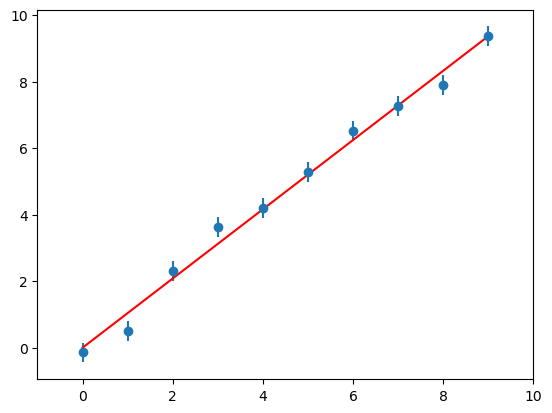

In [8]:
# Plot best fit line over the data
plt.errorbar(xdata, ydata, xerr=0, yerr=sigma, fmt='o')
plt.xlim(-1,Npoints)
xfit = np.linspace(0,Npoints-1.,50)
plt.plot(xfit,model(xfit, *par),'r-')
plt.show()

You can also do an *unweighted* fit if you do not know the uncertainties for each point. *curve_fit* will minimize 
$\mathcal{S} = \sum \left(y_i - y(x_i;\{a_j\})\right)^2$. You can use it to estimate the uncertainty for each point: 
$\sigma_i = \sqrt{\mathcal{S}/(N_\mathrm{data}-N_\mathrm{parameters})}$.

a=-0.001+/-0.196
b= 1.041+/-0.037
Generated error =  0.30
Computed error =  0.33


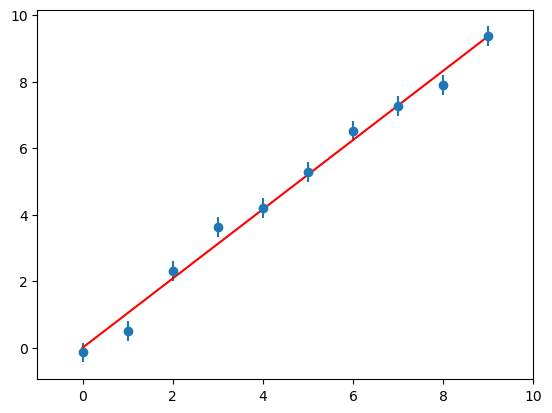

In [9]:
par0 = np.array([0,1]) # initial guess for parameters
par, cov = fitter.curve_fit(model, xdata, ydata, par0) # Now we don't know the errors

a0 = par[0]
error_a0 = np.sqrt(cov[0,0])
print ('a={0:6.3f}+/-{1:5.3f}'.format(a0,error_a0))
a1 = par[1]
error_a1 = np.sqrt(cov[1,1])
print ('b={0:6.3f}+/-{1:5.3f}'.format(a1,error_a1))

# Compute the error per point
sigCalc = np.sqrt(np.sum(((model(xdata, *par)-ydata))**2)/(len(xdata)-len(par)))
print ('Generated error = {0:5.2f}'.format(sig))
print ('Computed error = {0:5.2f}'.format(sigCalc))

# Plot best fit line over the data
plt.errorbar(xdata, ydata, xerr=0, yerr=sigma, fmt='o')
plt.xlim(-1,Npoints)
xfit = np.linspace(0,Npoints-1.,50)
plt.plot(xfit,model(xfit,*par),'r-')
plt.show()

## Exercise 1
The code in the cell immediately below will generate some data and store it in the arrays `xdata`, `ydata`, and `sigma`. Use the techniques above to a quadratic model of the form
$$y = a_0 + a_1 x + a_2 x^2$$

Plot the data and your best fit curve with error and print out the values and their uncertainties as above.

In [ ]:
# Generate artificial data for Exercise 6 and plot it

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as fitter
%matplotlib inline

# Generate artificial data = quadratic function with a0 = 0, a1=1, a2 = -0.3
# plus some noise.
a0 = 0.5
a1 = 1
a2 = -0.3
sig = 0.4
Npoints = 10

xdata = np.arange(0,Npoints,1.)
ydata = a0 + a1 * xdata + a2 * xdata **2 + sig * np.random.standard_normal(size=Npoints)
sigma = np.ones(Npoints)*sig
plt.scatter(xdata,ydata,color='b')
plt.errorbar(xdata,ydata, sigma, color='r',ls='none')
plt.xlim(-1,Npoints)
plt.show()

In [ ]:
# Your code for exercise 1

def model(x, a0, a1, a2):
    '''Define your model function according to the
       quadratic function given above.'''
    
# Use scipy.optimize.curve_fit() to fit the generated data and print the results
# Plot your fitted function over the data points to confirm you achieved a good fit

### Fitting to a distribution

`scipy.stats` package provides parameterizations of many standard probability density functions (PDFs). Each PDF has a *fit()* method, which does an *unbinned maximum likelihood fit* to a set of events, constraining the parameters of the PDF. Here is an example of a fit of a set of events to a Gaussian PDF.
Courtesy http://glowingpython.blogspot.com/2012/07/distribution-fitting-with-scipy.html

In [ ]:
from scipy.stats import norm # This gives us access to the normal distribution
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# generate 1000 events from a normal distrubution
# with actual mean 0 and actual standard deviation 1
sample = norm.rvs(loc=0,scale=1,size=1000) 

# fit this sample to a gaussian distribution, determine parameters (stored in par)
par = norm.fit(sample) 

print ('mean  = {0:4.2f}'.format(par[0]))
print ('sigma = {0:4.2f}'.format(par[1]))

# now, par[0] and par[1] are the mean and 
# the standard deviation of the fitted distribution

In [ ]:
# Plot the data and our fitted curve to visualize how well it fit

x = np.linspace(-5,5,100)

# fitted distribution
pdf_fitted = norm.pdf(x,loc=par[0],scale=par[1])

plt.title('Normal distribution')
plt.plot(x,pdf_fitted,'r-')
plt.hist(sample,density=True, alpha=.3)
plt.show()

Unfortunately, *scipy.stats.fit* does not provide an esitimate of the covariance matrix (or even the errors on the parameters). This is a major problem with doing max-likelihood fits using the *scipy.stats* package! (any respectable physicist needs to report errors for their measurements). There are more advanced tools for likelihood fitting that do provide error estimates -- but at this point they are beyond the scope of this class.

For a Gaussian distribution, and a few others, max-likelihood estimators have analytic formulae:

$\hat{\mu} = \frac{1}{N}\sum_{i=1}^N x_i$

$\hat{\sigma^2} = \frac{1}{N}\sum_{i=1}^N (x_i-\hat{\mu})^2$

In [ ]:
# generate 1000 events from a normal distrubution
# with actual mean 0 and actual standard deviation 1
sample = norm.rvs(loc=0,scale=1,size=1000) 

N = len(sample)

# These are the estimates for the mean and standard deviation given above
mean = np.mean(sample)
sigma = np.sqrt(np.sum((sample-mean)**2)/N)

# The estimates on the errors for the mean and standard deviation can be found in most statistics textbooks
eMean = sigma/np.sqrt(N)

# See https://stats.stackexchange.com/questions/156518/what-is-the-standard-error-of-the-sample-standard-deviation
eSigma = np.sqrt((np.sum((sample-mean)**4)/N-(N-3)/(N-1)*sigma**4)/N)

print ('Max-likelihood estimate of mean = {0:4.2f} +/- {1:4.2f}'.format(mean,eMean))
print ('Max-likelihood estimate of sigma = {0:4.2f} +/- {1:4.2f}'.format(sigma,eSigma))


## Exercise 2

A more common way to determine parameters of a distribution is to do perform a *binned least-squares fit*, i.e. fit a distribution to a histogram. When doing so, it is important to assign proper Poisson errors to each bin of a histogram. Here is how you can create a histogram with Poisson errors:

In [ ]:
# Generate data for Exercise 2
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# generate 1000 events from a normal distrubution
# with actual mean 0 and actual standard deviation 1
sample = norm.rvs(loc=0,scale=1,size=1000) 

The function `np.histogram()` allows us to convert our sample of 1000 normally distributed numbers to x values and y values with which we can perform a fit.  In this case, the y values are the heights of bars on the histogram, and the x values are the center position of each histogram bin.  The `np.histogram()` function needs a range over which we place the sample values into bins, along with the number of bins we would like to define over that range.

In [ ]:
# Use np.histogram() with our sample to generate an array of y_values
# (The y values would be the heights of each bar in the histogram)
y, bin_edges = np.histogram(sample, range=(-4,4),bins=40)

# bin_edges is an array of left/right edges of all bins 
# (40 bins are described by 41 edges)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
# x is now an array of the bin centers

# Poisson errors are just the square root of the number of counts in each bin
error_y = np.sqrt(y)
# We have to be careful to make sure errors are never zero, or the chi^2 fit would fail! 
# This next line assigns a minimum error of 1 to all bins
error_y = [max(error,1) for error in error_y]

# Here's a plot of our data
plt.errorbar(x,y,error_y, fmt='o')
plt.show()

Fit the data above using `scipy.optimize.curve_fit()`. The data are stored in the arrays `x`, `y`, and `error_y` (the estimated uncertainties).  Define your model function to be a Gaussian function with the form
$$ y(x) = Ae^{-\frac{(x-\mu)^2}{2\sigma^2}}$$


Your model function should have 3 free parameters: `A`, `mu`, and `sigma`.  Print the mean and sigma parameters and their uncertainties after fitting. Plot your function overlayed with the data points.

In [ ]:
# Your code for exercise 2

def model(x, A, mu, sigma):
    '''Define your model function according to 
       the Gaussian function given above.'''
    
# Use scipy.optimize.curve_fit() to fit the generated data and print the results
# Plot your fitted function over the data points to confirm you achieved a good fit

## Exercise 3 (useful for HW4)

In the cell below, 100 random (x,y) points are generated and plotted on a scatter plot.  You can change how *correlated* the x and y values are by adjusting the coefficient of the `0*data1` term.  Right now, `0` means there is no correlation.  In this exercise, let's look at a couple ways of quantifying correlation.

In [ ]:
import numpy as np
import scipy.optimize as fitter

data1 = np.random.randn(100)

data2 = np.random.randn(100) + 0*data1

plt.scatter(data1, data2)

First, as we've done before, use `scipy.optimize.curve_fit()` to fit the data to a line.  Then print the slope of the line of best fit. This is an example of <i>linear regression</i>

In [ ]:
def model(x, a0, a1):
    return a0 + a1*x

# Use curve_fit() with data1 and data2 
# Then print the fitted slope (a1)

The *correlation coefficient* can be found using `np.corrcoef(data1, data2)`.  This function returns a matrix; the off diagonal elements give the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between `data1` and `data2`.  Compare this value to the slope found above and the overall structure of the scatter plot.  Go back and change the `0*data1` term to something non-zero and see how this affects the scatter plot, slope, and correlation coefficient.

You don't have to type up any answers to these exploratory questions; the goal is to build some intuition for what it means for two sets of data to be correlated.  Also note that slopes and correlation coefficients are not the same thing.  The Pearson correlation coefficient is bounded between -1 and +1 (+1 indicates strong positive correlation and -1 indicates strong negative correlation).

In [ ]:
# print the Pearson correlation coefficient between data1 and data2
# go back and change 0*data1 to something like 3*data1 or -0.5*data1 and repeat

In HW4, you've defined your own correlation function.  If you have the time, repeat this now. It would also be instructive to compare output of your own function to what `scipy.stats.pearsonr()` returns. The Pearson correlation coefficient of a sample of (x,y) data points is defined as:

$r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$

Where $\bar{x}$ and $\bar{y}$ are the means of the $x$ and $y$ data sets.